In [24]:
%%capture
!pip install transformers --update
!pip install accelerate
# uncomment below cell to train on TPU's
#!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install git+https://github.com/huggingface/accelerate
!pip install ml_collections
!pip install datasets
!pip install pandas-profiling[notebook]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ml_collections
import datasets
import torch
import transformers
from accelerate import Accelerator, DistributedType
from datasets import load_metric, Dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
    AutoConfig,
    RobertaForSequenceClassification,
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import emoji
from wordcloud import WordCloud, STOPWORDS
import re,string, nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings(action="ignore")

[nltk_data] Downloading package punkt to /Users/colinlam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
# Setting up the model hyperparameters

def model_config():
    cfg_dictionary = {
        "data_path": "data.csv",
        "model_path": "/kaggle/working/bert_model.h5",
        "model_type": "transformer",

        "test_size": 0.1,
        "validation_size":0.2,
        "train_batch_size": 32,
        "eval_batch_size": 32,

        "epochs": 1,
        "adam_epsilon": 1e-8,
        "lr": 3e-5,
        "num_warmup_steps": 10,

        "max_length": 128,
        "random_seed": 42,
        "num_labels": 3,
        "model_checkpoint":"roberta-base",
    }
    cfg = ml_collections.FrozenConfigDict(cfg_dictionary)

    return cfg
cfg = model_config()

In [27]:
def clean_text(df,field):
    df[field] = df[field].str.replace(r"http\S+"," ")
    df[field] = df[field].str.replace(r"http"," ")
    df[field] = df[field].str.replace(r"@","at")
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    df[field] = df[field].str.lower()
    return df 
    
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm','im', 'll', 'y', 've', 
                      'u', 'ur', 'don','p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                      'de', 're', 'amp', 'will'])
    
def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(emoji.get_emoji_regexp(),"",text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    text = " ".join([stemmer.stem(word) for word in text.split()])
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(STOPWORDS)]
    text = ' '.join(text)
    return text

In [28]:
def preprocess_csv(csv_file: str) -> pd.DataFrame:
    df = pd.read_csv(csv_file)

    labelencoder = LabelEncoder()
    df["label_enc"] = labelencoder.fit_transform(df["Sentiment"])
    df.rename(columns={"label": "label_desc"}, inplace=True)
    df.rename(columns={"label_enc": "labels"}, inplace=True)
    df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)

    cleaned_df = clean_text(df, "Sentence")
    
    if cfg.model_type is not "transformer":
        cleaned_df["Sentence"] = cleaned_df["Sentence"].apply(preprocess_text)
    return cleaned_df

In [29]:
df = preprocess_csv(cfg.data_path)
profile = ProfileReport(df, title="Financial Sentiment Analysis")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["Sentence"]),np.array(df["labels"]), test_size=0.25, random_state=42)


In [31]:
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize,min_df=0.00002,max_df=0.70)
X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

print(f"TF_IDF Model: Train features shape:{X_train_tf.shape} and Test features shape:{X_test_tf.shape}")

TF_IDF Model: Train features shape:(3991, 8649) and Test features shape:(1331, 8649)


In [32]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=42)
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)
nb = MultinomialNB()
mlp = MLPClassifier(random_state=42)

clfs = {
    "Random Forest": rf,
    "Gradient Boosting":gb,
    "AdaBoost": ada,
    "LightGBM": lgb,
    "XGBoost": xgb,
    "Decision Tree":dt,
    "Support Vector Machine":svc,
    "Naive Bayes": nb,
    "Multilayer Perceptron":mlp
}

def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

accuracys = []

for name,clf in tqdm(clfs.items()):
    curr_acc = fit_model(clf,X_train_tf,y_train,X_test_tf,y_test)
    accuracys.append(curr_acc)

  0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
models_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Scores":accuracys}).sort_values('Accuracy Scores',ascending=False)
models_df

,Models,Accuracy Scores
6,Support Vector Machine,0.752066
4,XGBoost,0.740796
3,LightGBM,0.724267
0,Random Forest,0.712998
8,Multilayer Perceptron,0.712246
1,Gradient Boosting,0.710744
2,AdaBoost,0.694966
7,Naive Bayes,0.686702
5,Decision Tree,0.617581


In [34]:
def create_dataset(dataframe):
    training_df, test_df = train_test_split(
        dataframe,
        test_size=cfg.test_size,
        random_state=cfg.random_seed,
        stratify=dataframe.labels.values,
    )
    train_df, val_df = train_test_split(
        training_df,
        test_size=cfg.validation_size,
        random_state=cfg.random_seed,
        stratify=training_df.labels.values,
    )

    dataset = {
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df),
    }

    dataset = DatasetDict(dataset)

    return dataset

In [35]:
def tokenize_dataset():
    dataset = create_dataset(preprocess_csv(cfg.data_path))
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_checkpoint,use_fast=True)

    def tokenize_function(sample):
        outputs = tokenizer(
            sample["Sentence"],
            truncation=True,
            padding="max_length",
            max_length=cfg.max_length,
        )
        return outputs

    tokenized_datasets = dataset.map(
        tokenize_function, batched=True, remove_columns=["Sentence","Sentiment","__index_level_0__"]
    )
    tokenized_datasets.set_format("torch")

    return tokenized_datasets

In [36]:
def create_dataloaders():
    tokenized_datasets = tokenize_dataset()
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=cfg.train_batch_size
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"], shuffle=False, batch_size=cfg.eval_batch_size
    )
    return train_dataloader, eval_dataloader

In [80]:
def training_function():
    accelerator = Accelerator()

    set_seed(cfg.random_seed)
    tokenized_datasets = tokenize_dataset()
    accuracy = load_metric("accuracy")

    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    train_dataloader, eval_dataloader = create_dataloaders()
    model = AutoModelForSequenceClassification.from_pretrained(
        cfg.model_checkpoint, num_labels=cfg.num_labels
    )
    optimizer = torch.optim.AdamW(
        params=model.parameters(), eps=cfg.adam_epsilon, lr=cfg.lr
    )
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=cfg.num_warmup_steps,
        num_training_steps=len(train_dataloader) * cfg.epochs,
    )
    progress_bar = tqdm(
        range(cfg.epochs * len(train_dataloader)),
        disable=not accelerator.is_main_process,
    )

    # Model Training
    for epoch in range(cfg.epochs):
        model.train()
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        all_predictions = []
        all_labels = []

        for step, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)

            # gather predictions and labels from the 8 TPUs
            all_predictions.append(accelerator.gather(predictions))
            all_labels.append(accelerator.gather(batch["labels"]))

        # Concatenate all predictions and labels.
        all_predictions = torch.cat(all_predictions)[
            : len(tokenized_datasets["validation"])
        ]
        all_labels = torch.cat(all_labels)[: len(tokenized_datasets["validation"])]

        eval_accuracy = accuracy.compute(
            predictions=all_predictions, references=all_labels
        )

        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}:", eval_accuracy)
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    accelerator.save(unwrapped_model.state_dict(), "model")

In [81]:
from accelerate import notebook_launcher
notebook_launcher(training_function, num_processes=1)

Launching training on CPU.


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/colinlam/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
 

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/colinlam/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
 

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/colinlam/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",


  0%|          | 0/120 [00:00<?, ?it/s]

tensor([2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 0, 1, 2])
tensor([1, 2, 2, 2, 0, 1, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 2, 1,
        1, 1, 1, 2, 1, 2, 2, 1])
tensor([1, 1, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1,
        2, 2, 2, 2, 1, 1, 1, 2])
tensor([1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 1, 1, 2,
        1, 1, 2, 1, 0, 2, 2, 2])
tensor([2, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1,
        1, 2, 2, 2, 1, 1, 0, 1])
tensor([2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1,
        1, 1, 2, 1, 2, 1, 0, 1])
tensor([2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2,
        1, 2, 1, 1, 2, 1, 1, 0])
tensor([0, 2, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1,
        1, 2, 1, 0, 1, 2, 2, 1])
tensor([2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0,
        2, 1, 1,

In [92]:
RoBERTa = {'Models': 'RoBERTa', 'Accuracy Scores': 0.8262}
models_df = models_df.append(RoBERTa, ignore_index = True)
def make_prediction(input):
    model = AutoModelForSequenceClassification.from_pretrained(
        cfg.model_checkpoint, num_labels=cfg.num_labels,
    )
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_checkpoint,use_fast=True)
    state_dict = torch.load("model")
    model.load_state_dict(state_dict)
    inputs = tokenizer("APPL stock price is dropping", return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs).logits
    predicted_class_id = outputs.argmax(dim=-1).item()
    print(model.config.id2label[predicted_class_id])
make_prediction("I love APPL stocks")

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/colinlam/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",


LABEL_0


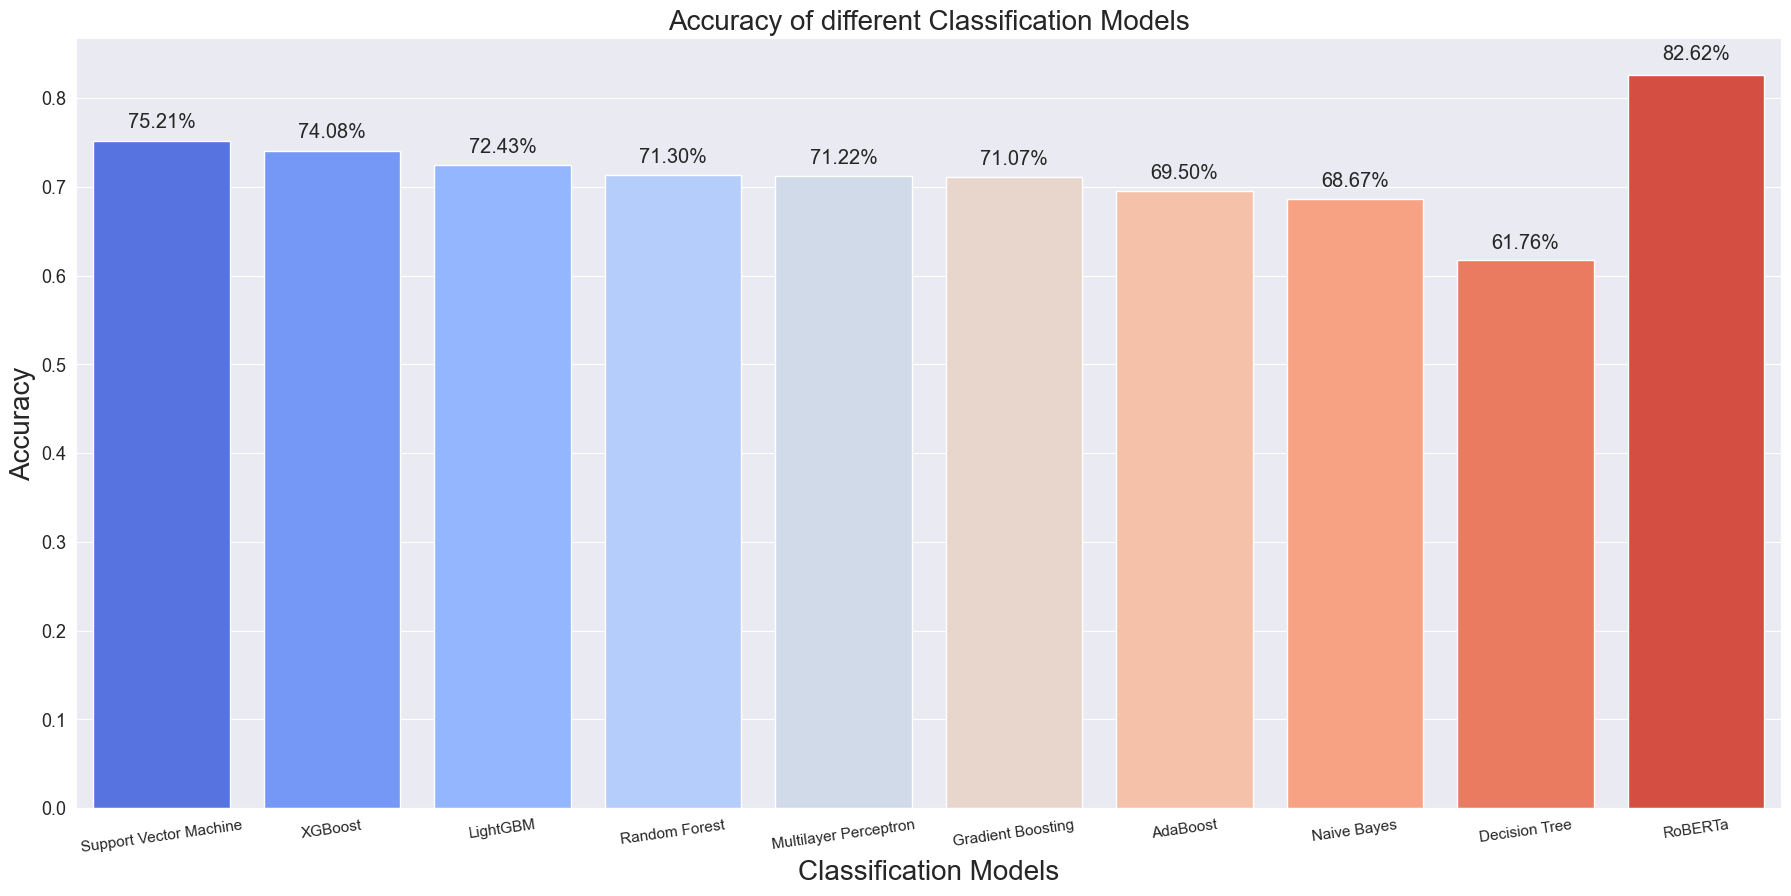

In [40]:
plt.rcParams['figure.figsize']=22,10
sns.set_style("darkgrid")
ax = sns.barplot(x=models_df["Models"], y=models_df["Accuracy Scores"], palette = "coolwarm", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

In [2]:
!python3 -m spacy download en_core_web_md

/Users/colinlam/miniconda3/envs/mentorship/bin/python3: No module named spacy


In [ ]:
import os
import sys
!{sys.executable} -m spacy info 
import time
import spacy

nlp = spacy.load('en_core_web_md')

In [ ]:
input = "test if this works"

words = []
noun_chunks = []
entities = []
content = []

doc = nlp(input)
content.append(doc)
words.extend([w for w in list(doc) if w.is_alpha])
noun_chunks.extend(list(doc.noun_chunks))
entities.extend(list(doc.ents))

In [ ]:
#the bot.py code:

import requests
import os
import json
import torch
import ml_collections
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
    AutoConfig,
    RobertaForSequenceClassification,
)

# To set your enviornment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = os.environ.get("BEARER_TOKEN")

# Setting up the model hyperparameters
def model_config():
    cfg_dictionary = {
        "data_path": "data.csv",
        "model_path": "/kaggle/working/bert_model.h5",
        "model_type": "transformer",

        "test_size": 0.1,
        "validation_size":0.2,
        "train_batch_size": 32,
        "eval_batch_size": 32,

        "epochs": 1,
        "adam_epsilon": 1e-8,
        "lr": 3e-5,
        "num_warmup_steps": 10,

        "max_length": 128,
        "random_seed": 42,
        "num_labels": 3,
        "model_checkpoint":"roberta-base",
    }
    cfg = ml_collections.FrozenConfigDict(cfg_dictionary)

    return cfg
cfg = model_config()

# Gets model
model = AutoModelForSequenceClassification.from_pretrained(
    cfg.model_checkpoint, num_labels=cfg.num_labels,
)

# Prepares tokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model_checkpoint,use_fast=True)
state_dict = torch.load("model")
model.load_state_dict(state_dict)


def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FilteredStreamPython"
    return r


def get_rules():
    response = requests.get(
        "https://api.twitter.com/2/tweets/search/stream/rules", auth=bearer_oauth
    )
    if response.status_code != 200:
        raise Exception(
            "Cannot get rules (HTTP {}): {}".format(response.status_code, response.text)
        )
    print(json.dumps(response.json()))
    return response.json()


def delete_all_rules(rules):
    if rules is None or "data" not in rules:
        return None

    ids = list(map(lambda rule: rule["id"], rules["data"]))
    payload = {"delete": {"ids": ids}}
    response = requests.post(
        "https://api.twitter.com/2/tweets/search/stream/rules",
        auth=bearer_oauth,
        json=payload
    )
    if response.status_code != 200:
        raise Exception(
            "Cannot delete rules (HTTP {}): {}".format(
                response.status_code, response.text
            )
        )
    print(json.dumps(response.json()))


def set_rules(delete):
    # You can adjust the rules if needed
    sample_rules = [
        {"value": "stock", "tag": "market"},
    ]
    payload = {"add": sample_rules}
    response = requests.post(
        "https://api.twitter.com/2/tweets/search/stream/rules",
        auth=bearer_oauth,
        json=payload,
    )
    if response.status_code != 201:
        raise Exception(
            "Cannot add rules (HTTP {}): {}".format(response.status_code, response.text)
        )
    print(json.dumps(response.json()))

def make_prediction(input):
    # Gets prediction from input
    inputs = tokenizer(input, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs).logits
    predicted_class_id = outputs.argmax(dim=-1).item()

    prediction = model.config.id2label[predicted_class_id]

    if (prediction == "LABEL_1"):
        print(input, "NEUTRAL")
    elif (prediction == "LABEL_0"):
        print(input, "NEGATIVE")
    else:
        print(input, "POSITIVE")


def get_stream(set):
    response = requests.get(
        "https://api.twitter.com/2/tweets/search/stream", auth=bearer_oauth, stream=True,
    )
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Cannot get stream (HTTP {}): {}".format(
                response.status_code, response.text
            )
        )
    for response_line in response.iter_lines():
        if response_line:
            json_response = json.loads(response_line)
            make_prediction(json_response["data"]["text"])


def main():
    rules = get_rules()
    delete = delete_all_rules(rules)
    set = set_rules(delete)
    get_stream(set)


if __name__ == "__main__":
    main()